## descriptive stats
* generate descriptive statistics in the data set

In [78]:
!pip install pandas openpyxl seaborn scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 50.3 MB/s eta 0:00:00:00:0100:01


In [326]:
# import packages
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import ks_2samp, mannwhitneyu

### load and preprocess data

In [9]:
df = pd.read_excel('examination sheet.xlsx',sheet_name='Sheet1')

In [10]:
df.columns

Index(['author', 'created_utc', 'title', 'selftext', 'note', 'Jurisdictions',
       'Relevance', 'Poster's legal status', 'misconception ',
       'unclear knowledge', 'Category', 'Background',
       'Is takedown procedure involved? ', 'round 1 cross examination',
       'round 2 cross examination', 'The meaning of registration',
       'The meaning of copyright', 'Registration subject matter: idea',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Infringement: how to prevent others from infringing my work',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'first_local',
       'count_local', 'first_global', 'count_global'],
      dtype='object')

In [304]:
df_sub = df[['author', 'created_utc', 'title', 'selftext', 'note', 'Jurisdictions',
             'Relevance', "Poster's legal status", 'misconception ',
             'unclear knowledge', 'Category', 'Background',
             'Is takedown procedure involved? ', 'count_local','count_global']].copy()

sel_rel = df_sub['Relevance']=='relevant'
sel_misconcep = df_sub['misconception ']=='#'
sel_unclear_knowledge = df_sub['unclear knowledge']=='#'

df_sub.loc[(sel_rel & sel_misconcep)==True, 'misconception ']='NaN'
df_sub.loc[(sel_rel & sel_unclear_knowledge)==True, 'unclear knowledge'] = 'NaN'

df_sub.loc[:,'text_len'] = df_sub['selftext'].apply(lambda x: 0 if pd.isna(x) else len(x))

# count repetitions for non-NA title and selftext

df_sub['rep_counts'] = df_sub.groupby(['title','selftext']).transform('size')

# manually set the rep_counts=1 for the single case that doesn't have title but have selftext
df_sub.loc[df_sub['title'].isna(), 'rep_counts'] = 1

# if selftext is na, count title only
df_sub.loc[df_sub['selftext'].isna(), 'rep_counts'] = df_sub[df_sub['selftext'].isna()].groupby(['title']).transform('size')
df_sub['rep_counts'] = df_sub['rep_counts'].astype('int64')

# drop duplicates
df_sub.drop_duplicates(subset=['title', 'selftext'], keep='first', inplace=True)

### duplication and relevance

In [307]:
df_sub['is_rep'] = df_sub['rep_counts'].apply(lambda x: 1 if x>1 else 0)

In [308]:
sel = df_sub['Relevance'] == 'relevant'

In [309]:
df_sub.loc[sel, 'is_relevant'] = 1
df_sub.loc[~sel, 'is_relevant'] = 0
df_sub['is_relevant'] = df_sub['is_relevant'].astype('int64')

In [310]:


# Example binary arrays (replace with your actual data)
array1 = df_sub['is_rep']
array2 = df_sub['is_relevant']

# Create a contingency table
a = np.sum((array1 == 0) & (array2 == 0))
b = np.sum((array1 == 0) & (array2 == 1))
c = np.sum((array1 == 1) & (array2 == 0))
d = np.sum((array1 == 1) & (array2 == 1))

contingency_table = np.array([[a, b], [c, d]])

# Perform Chi-Squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Squared Statistic: {chi2_stat}, p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant association (reject H₀: variables are independent)")
else:
    print("No significant association (fail to reject H₀)")


Chi-Squared Statistic: 1.1770821015161919, p-value: 0.27795082318934633
No significant association (fail to reject H₀)


In [311]:
contingency_table # seems that significance due to 0-inflation

array([[1775, 1045],
       [  97,   69]])

In [312]:


# Example zero-inflated binary arrays
array1 = df_sub['is_rep']
array2 = df_sub['is_relevant']

# Create full contingency table
a = np.sum((array1 == 0) & (array2 == 0))  # Majority (0,0)
b = np.sum((array1 == 0) & (array2 == 1))
c = np.sum((array1 == 1) & (array2 == 0))
d = np.sum((array1 == 1) & (array2 == 1))

full_table = np.array([[a, b], [c, d]])

# Create contingency table **excluding (0,0) cases** to fix zero-inflation issue
filtered_table = np.array([[b, d], [c, np.nan]])  # NaN to prevent chi-squared issues

print("Original Contingency Table:")
print(pd.DataFrame(full_table, index=["Array1=0", "Array1=1"], columns=["Array2=0", "Array2=1"]))

print("\nFiltered Contingency Table (Excluding (0,0)):")
print(pd.DataFrame(filtered_table, index=["Array1=0", "Array1=1"], columns=["Array2=0", "Array2=1"]))

# Use only the non-zero part of the contingency table
chi2_stat, chi2_p, dof, expected = chi2_contingency(full_table, correction=True)

print(f"\nChi-Squared Test (Zero-Inflation Adjusted):")
print(f"Chi-Squared Statistic: {chi2_stat}, p-value: {chi2_p}\n")

# Compute OR using Fisher’s Exact Test
odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]])

# Compute Standard Error (SE) of log(OR)
if a > 0 and b > 0 and c > 0 and d > 0:
    se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
    log_or = np.log(odds_ratio)
    
    # 95% Confidence Interval
    z = 1.96  # 95% CI
    #z = 1.645 # 90% CI
    ci_lower = np.exp(log_or - z * se_log_or)
    ci_upper = np.exp(log_or + z * se_log_or)
    
    print(f"Odds Ratio: {odds_ratio:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})")
    print(f"Fisher’s Exact Test p-value: {fisher_p:.3f}")
else:
    print("Confidence interval cannot be computed due to zero counts.")

Original Contingency Table:
          Array2=0  Array2=1
Array1=0      1775      1045
Array1=1        97        69

Filtered Contingency Table (Excluding (0,0)):
          Array2=0  Array2=1
Array1=0    1045.0      69.0
Array1=1      97.0       NaN

Chi-Squared Test (Zero-Inflation Adjusted):
Chi-Squared Statistic: 1.1770821015161919, p-value: 0.27795082318934633

Odds Ratio: 1.208
95% Confidence Interval: (0.879, 1.661)
Fisher’s Exact Test p-value: 0.248


In [313]:
df_sub['Relevance'] = df_sub['Relevance'].fillna('irrelevant')

In [314]:
#sel_vague = df_sub['Relevance']=='vague'
df_sub['is_relevant'] = 0
df_sub.loc[df_sub['Relevance'].str.contains('relevant'), 'is_relevant']=1
df_sub.loc[df_sub['Relevance'].str.contains('irrelevant'), 'is_relevant'] = 0

In [316]:
# Example zero-inflated binary arrays
array1 = df_sub['is_rep']
array2 = df_sub['is_relevant']

# Create full contingency table
a = np.sum((array1 == 0) & (array2 == 0))  # Majority (0,0)
b = np.sum((array1 == 0) & (array2 == 1))
c = np.sum((array1 == 1) & (array2 == 0))
d = np.sum((array1 == 1) & (array2 == 1))

full_table = np.array([[a, b], [c, d]])

# Create contingency table **excluding (0,0) cases** to fix zero-inflation issue
filtered_table = np.array([[b, d], [c, np.nan]])  # NaN to prevent chi-squared issues

print("Original Contingency Table:")
print(pd.DataFrame(full_table, index=["Array1=0", "Array1=1"], columns=["Array2=0", "Array2=1"]))

print("\nFiltered Contingency Table (Excluding (0,0)):")
print(pd.DataFrame(filtered_table, index=["Array1=0", "Array1=1"], columns=["Array2=0", "Array2=1"]))

# Use only the non-zero part of the contingency table
chi2_stat, chi2_p, dof, expected = chi2_contingency(full_table, correction=True)

print(f"\nChi-Squared Test (Zero-Inflation Adjusted):")
print(f"Chi-Squared Statistic: {chi2_stat}, p-value: {chi2_p}\n")

# Compute OR using Fisher’s Exact Test
odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]])

# Compute Standard Error (SE) of log(OR)
if a > 0 and b > 0 and c > 0 and d > 0:
    se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
    log_or = np.log(odds_ratio)
    
    # 95% Confidence Interval
    z = 1.96  # 95% CI
    #z = 1.645 # 90% CI
    ci_lower = np.exp(log_or - z * se_log_or)
    ci_upper = np.exp(log_or + z * se_log_or)
    
    print(f"Odds Ratio: {odds_ratio:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})")
    print(f"Fisher’s Exact Test p-value: {fisher_p:.3f}")
else:
    print("Confidence interval cannot be computed due to zero counts.")

Original Contingency Table:
          Array2=0  Array2=1
Array1=0      1643      1177
Array1=1        82        84

Filtered Contingency Table (Excluding (0,0)):
          Array2=0  Array2=1
Array1=0    1177.0      84.0
Array1=1      82.0       NaN

Chi-Squared Test (Zero-Inflation Adjusted):
Chi-Squared Statistic: 4.693069335533469, p-value: 0.03028450428059145

Odds Ratio: 1.430
95% Confidence Interval: (1.045, 1.956)
Fisher’s Exact Test p-value: 0.029


**conclusion: repetition and relevance are not significantly associated**

### text length and relevance

In [321]:
sel = df_sub['is_relevant']==1
value_1 = df_sub[sel]['text_len']
value_0 = df_sub[~sel]['text_len']

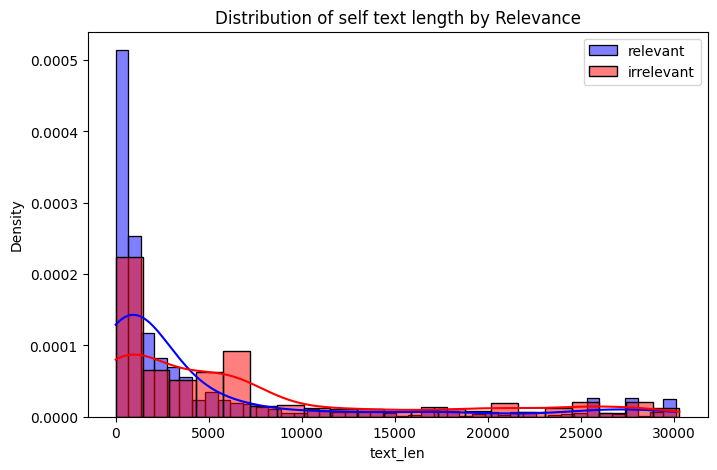

In [322]:
plt.figure(figsize=(8,5))
sns.histplot(value_1, color="blue", label="relevant", kde=True, stat="density", alpha=0.5)
sns.histplot(value_0, color="red", label="irrelevant", kde=True, stat="density", alpha=0.5)
plt.legend()
plt.title("Distribution of self text length by Relevance")
plt.show()

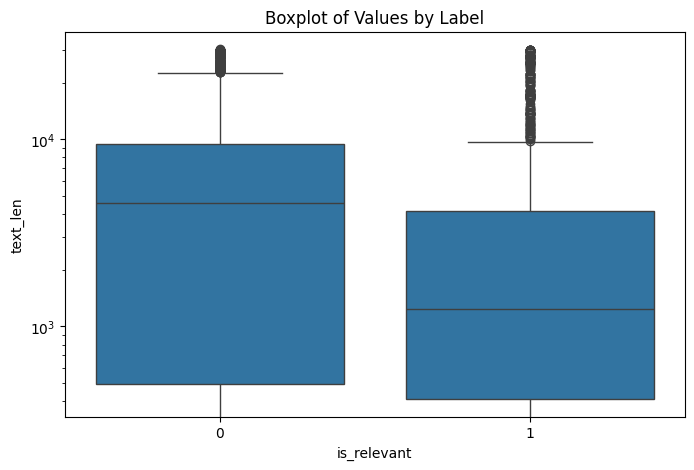

In [324]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_sub['is_relevant'], y=df_sub['text_len'])
plt.yscale("log")  # Log-scale for better visualization
plt.title("Boxplot of Values by Label")
plt.show()

In [325]:

ks_stat, ks_p = ks_2samp(value_0, value_1)
print(f"KS Test Statistic: {ks_stat}, p-value: {ks_p}")

mw_stat, mw_p = mannwhitneyu(value_0, value_1, alternative='greater')
print(f"Mann-Whitney U Test Statistic: {mw_stat}, p-value: {mw_p}")

median_0 = value_0.median()
median_1 = value_1.median()

print(f"Median for Label 0: {median_0}")
print(f"Median for Label 1: {median_1}")

KS Test Statistic: 0.2675456561964854, p-value: 2.3006186478983728e-46
Mann-Whitney U Test Statistic: 1321080.0, p-value: 5.2141191148543035e-24
Median for Label 0: 4558.0
Median for Label 1: 1234.0


**conclusion: selftext length and relevance are significantly associated.**